C:\Users\조여원\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "importance_type", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:0.60908	valid-mlogloss:0.60908
[1]	train-mlogloss:0.33611	valid-mlogloss:0.33611
[2]	train-mlogloss:0.19486	valid-mlogloss:0.19486
[3]	train-mlogloss:0.11536	valid-mlogloss:0.11536
[4]	train-mlogloss:0.06902	valid-mlogloss:0.06902
[5]	train-mlogloss:0.04155	valid-mlogloss:0.04155
[6]	train-mlogloss:0.02511	valid-mlogloss:0.02511
[7]	train-mlogloss:0.01521	valid-mlogloss:0.01521
[8]	train-mlogloss:0.00924	valid-mlogloss:0.00924
[9]	train-mlogloss:0.00562	valid-mlogloss:0.00562
[10]	train-mlogloss:0.00344	valid-mlogloss:0.00344
[11]	train-mlogloss:0.00211	valid-mlogloss:0.00211
[12]	train-mlogloss:0.00130	valid-mlogloss:0.00130
[13]	train-mlogloss:0.00082	valid-mlogloss:0.00082
[14]	train-mlogloss:0.00052	valid-mlogloss:0.00052
[15]	train-mlogloss:0.00034	valid-mlogloss:0.00034
[16]	train-mlogloss:0.00023	valid-mlogloss:0.00023
[17]	train-mlogloss:0.00016	valid-mlogloss:0.00016
[18]	train-mlogloss:0.00011	valid-mlogloss:0.00011
[19]	train-mlogloss:0.00009	valid-mloglos

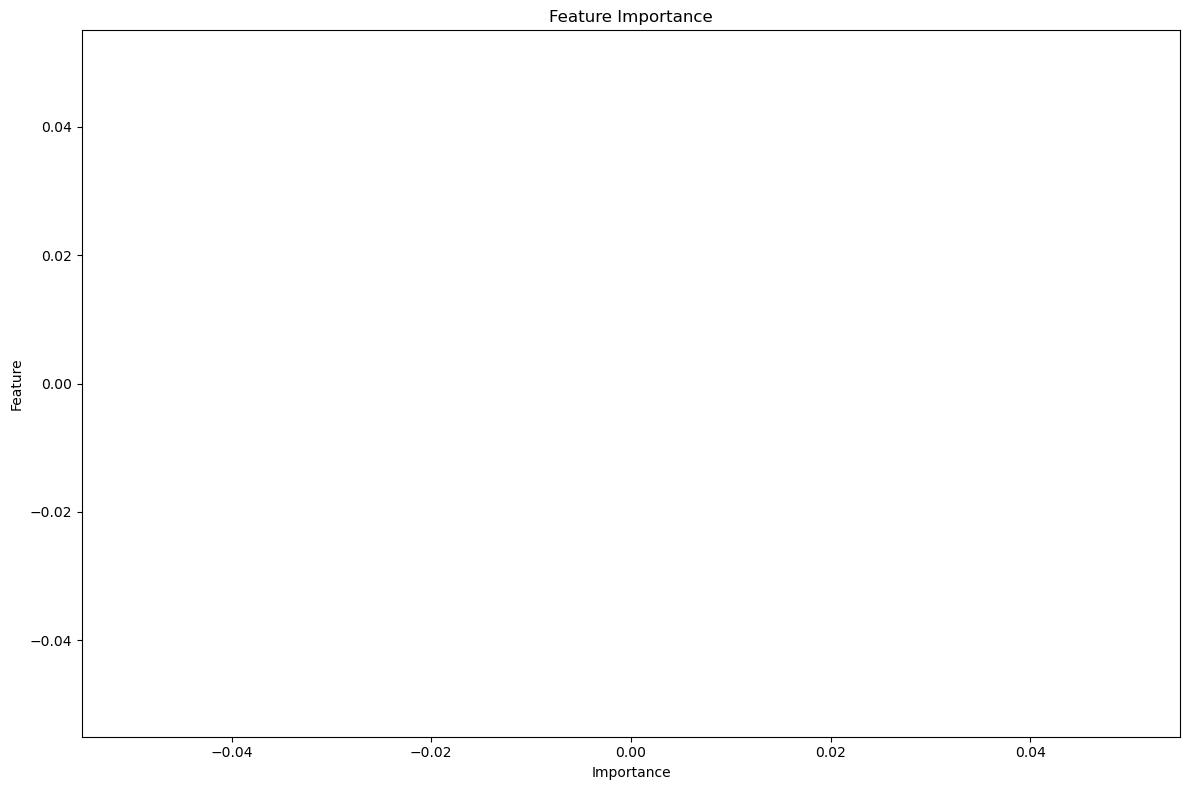

Training Data Evaluation:
Confusion Matrix:
[[14031]]
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000

Validation Data Evaluation:
Confusion Matrix:
[[3508]]
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

# 데이터셋 불러오기
df_train = pd.read_csv('1.옥외누수(out-training).csv')

# 특성 선택
x_train = df_train.iloc[:, [3, 4] + list(range(6, df_train.shape[1]))]

# 타겟 선택
y_train = df_train.iloc[:, 5]

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# 데이터 분할
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# XGBoost 모델 설정
params = {
    'base_score': 0.5, 
    'booster': 'gbtree', 
    'colsample_bylevel': 1,
    'colsample_bynode': 1, 
    'colsample_bytree': 1, 
    'eval_metric': 'mlogloss',
    'gamma': 0, 
    'importance_type': 'gain',
    'interaction_constraints': '', 
    'learning_rate': 0.5, 
    'max_delta_step': 0,
    'max_depth': 6, 
    'min_child_weight': 1,
    'monotone_constraints': '()', 
    'n_estimators': 100, 
    'n_jobs': 0,
    'num_class': 5, 
    'num_parallel_tree': 1, 
    'objective': 'multi:softprob',
    'random_state': 42, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': None,
    'seed': 42, 
    'subsample': 1, 
    'tree_method': 'exact', 
    'validate_parameters': 1,
    'verbosity': None
}

# DMatrix 생성
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

num_rounds = 100
evals = [(dtrain, 'train'), (dvalid, 'valid')]  # 평가용 데이터 세트 추가

# 모델 학습
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=evals, verbose_eval=True)

# 예측
y_pred_train = model.predict(dtrain)
y_pred_valid = model.predict(dvalid)

# 특성 중요도 추출
importance = model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
feature_names = [x[0] for x in sorted_importance]
importance_values = [x[1] for x in sorted_importance]

# 특성 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
})

# 중요도 값에 따라 오름차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# 특성 중요도를 시각화
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')

for bar, importance in zip(bars, feature_importance_df['Importance']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.4f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.tight_layout()
plt.show()

# 분류 메트릭스를 위한 평가 함수
def get_clf_eval(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Confusion Matrix:")
    print(confusion)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# 학습 데이터 평가
print("Training Data Evaluation:")
get_clf_eval(y_train, np.argmax(y_pred_train, axis=1))

# 검증 데이터 평가
print("\nValidation Data Evaluation:")
get_clf_eval(y_valid, np.argmax(y_pred_valid, axis=1))


[0]	train-mlogloss:0.60947	valid-mlogloss:0.60947
[1]	train-mlogloss:0.33642	valid-mlogloss:0.33642
[2]	train-mlogloss:0.19512	valid-mlogloss:0.19512
[3]	train-mlogloss:0.11558	valid-mlogloss:0.11558
[4]	train-mlogloss:0.06923	valid-mlogloss:0.06923


C:\Users\조여원\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [21:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "importance_type", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-mlogloss:0.04175	valid-mlogloss:0.04175
[6]	train-mlogloss:0.02529	valid-mlogloss:0.02529
[7]	train-mlogloss:0.01539	valid-mlogloss:0.01539
[8]	train-mlogloss:0.00941	valid-mlogloss:0.00941
[9]	train-mlogloss:0.00579	valid-mlogloss:0.00579
[10]	train-mlogloss:0.00360	valid-mlogloss:0.00360
[11]	train-mlogloss:0.00227	valid-mlogloss:0.00227
[12]	train-mlogloss:0.00146	valid-mlogloss:0.00146
[13]	train-mlogloss:0.00096	valid-mlogloss:0.00096
[14]	train-mlogloss:0.00065	valid-mlogloss:0.00065
[15]	train-mlogloss:0.00046	valid-mlogloss:0.00046
[16]	train-mlogloss:0.00038	valid-mlogloss:0.00038
[17]	train-mlogloss:0.00031	valid-mlogloss:0.00031
[18]	train-mlogloss:0.00026	valid-mlogloss:0.00026
[19]	train-mlogloss:0.00022	valid-mlogloss:0.00022
[20]	train-mlogloss:0.00019	valid-mlogloss:0.00019
[21]	train-mlogloss:0.00016	valid-mlogloss:0.00016
[22]	train-mlogloss:0.00014	valid-mlogloss:0.00014
[23]	train-mlogloss:0.00012	valid-mlogloss:0.00012
[24]	train-mlogloss:0.00012	valid-ml

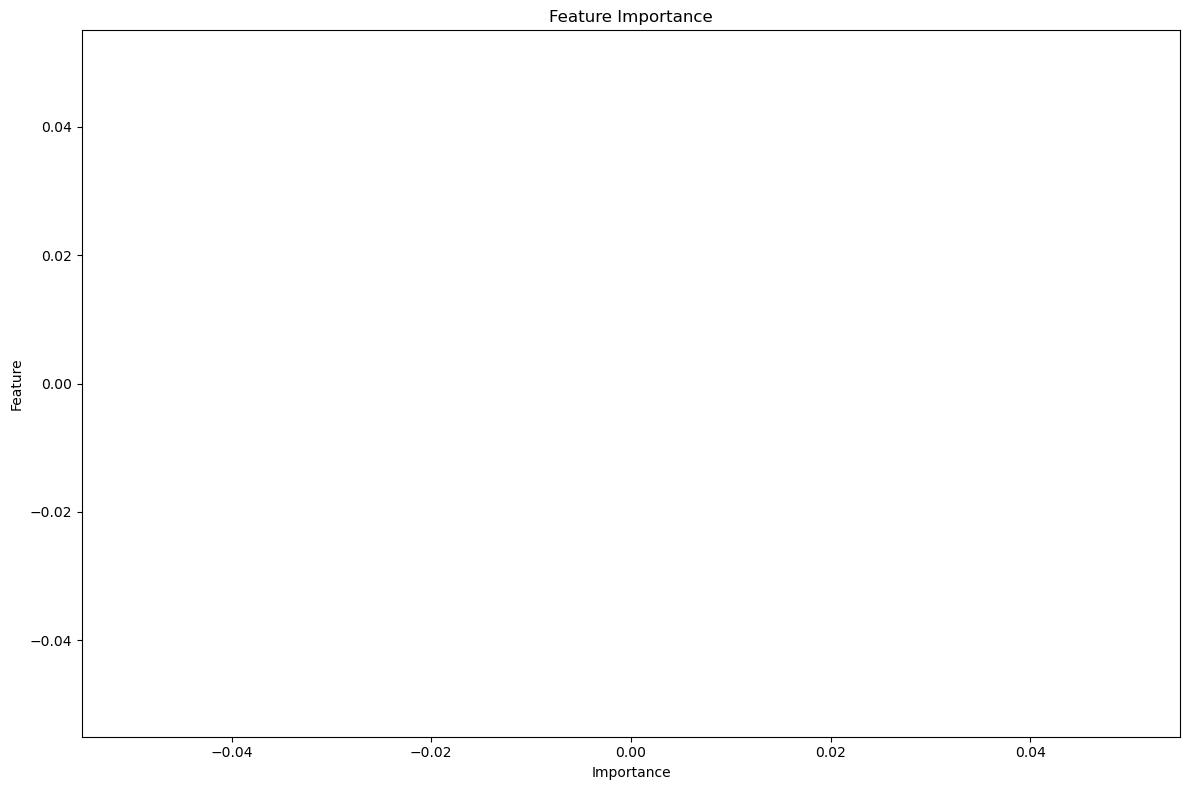

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import f1_score, roc_auc_score
# 데이터셋 불러오기
df_train = pd.read_csv('3.기계.전기음(noise-training).csv')

# 특성 선택
x_train = df_train.iloc[:, [3, 4] + list(range(6, df_train.shape[1]))]

# 타겟 선택
y_train = df_train.iloc[:, 5]

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# 데이터 분할
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# XGBoost 모델 설정
params = {
    'base_score': 0.5, 
    'booster': 'gbtree', 
    'colsample_bylevel': 1,
    'colsample_bynode': 1, 
    'colsample_bytree': 1, 
    'eval_metric': 'mlogloss',
    'gamma': 0, 
    'importance_type': 'gain',
    'interaction_constraints': '', 
    'learning_rate': 0.5, 
    'max_delta_step': 0,
    'max_depth': 6, 
    'min_child_weight': 1,
    'monotone_constraints': '()', 
    'n_estimators': 100, 
    'n_jobs': 0,
    'num_class': 5, 
    'num_parallel_tree': 1, 
    'objective': 'multi:softprob',
    'random_state': 42, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': None,
    'seed': 42, 
    'subsample': 1, 
    'tree_method': 'exact', 
    'validate_parameters': 1,
    'verbosity': None
}

# DMatrix 생성
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

num_rounds = 100
evals = [(dtrain, 'train'), (dvalid, 'valid')]  # 평가용 데이터 세트 추가

# 모델 학습
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=evals, verbose_eval=True)

# 예측
y_pred_train = model.predict(dtrain)
y_pred_valid = model.predict(dvalid)

# 학습 데이터와 검증 데이터 예측
y_pred_train = model.predict(dtrain)
y_pred_valid = model.predict(dvalid)

# 학습 데이터 평가
print("Training Data Evaluation:")
get_clf_eval(y_train, np.argmax(y_pred_train, axis=1))

# 검증 데이터 평가
print("\nValidation Data Evaluation:")
get_clf_eval(y_valid, np.argmax(y_pred_valid, axis=1))





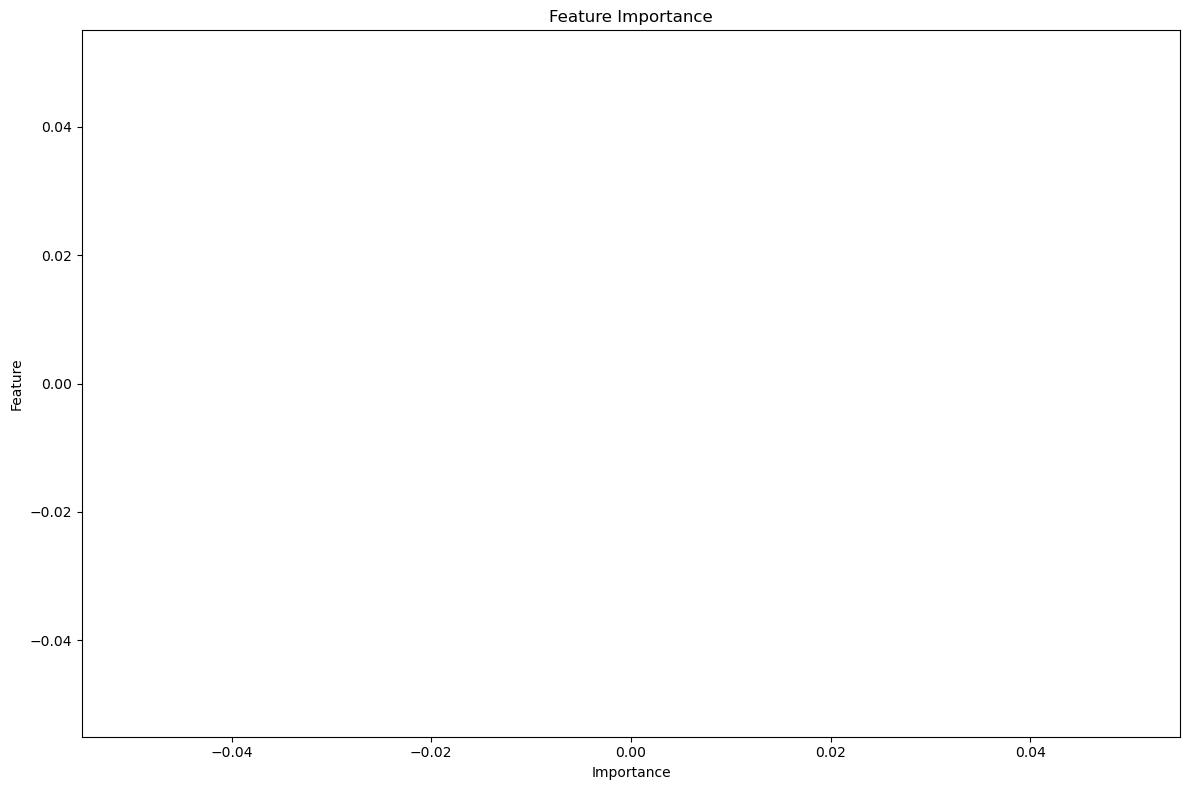

In [21]:
# 특성 중요도 추출
importance = model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
feature_names = [x[0] for x in sorted_importance]
importance_values = [x[1] for x in sorted_importance]

# 특성 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
})

# 중요도 값에 따라 오름차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# 특성 중요도를 시각화
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')

for bar, importance in zip(bars, feature_importance_df['Importance']):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.4f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.tight_layout()
plt.show()

# 분류 메트릭스를 위한 평가 함수
def get_clf_eval(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Confusion Matrix:")
    print(confusion)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")



In [17]:
x_train

,lrate,llevel,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,...,MAX10,MAX11,MAX12,MAX13,MAX14,MAX15,MAX16,MAX17,MAX18,MAX19
1609,90,830,0,3,0,0,0,0,3,3,...,240,717,240,969,240,951,240,887,240,822
996,90,288,0,3,4,4,4,5,5,8,...,250,247,250,319,250,321,250,186,250,869
4746,90,417,0,4,4,4,4,3,5,4,...,270,664,270,630,290,322,270,164,290,380
3220,90,650,0,0,3,3,3,3,3,3,...,370,690,370,431,370,547,370,661,370,738
2361,90,699,0,0,0,3,3,3,3,3,...,240,723,240,629,240,568,240,897,240,807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,90,1252,0,0,0,5,5,0,0,0,...,360,1252,360,1252,360,1252,360,1252,360,1253
466,90,403,0,3,3,3,3,3,4,3,...,230,394,230,472,250,434,240,396,230,340
3092,90,972,0,4,4,4,8,8,11,8,...,240,940,240,867,240,555,240,941,240,1232
3772,90,627,0,2,2,2,2,2,2,2,...,240,915,240,576,240,542,240,870,250,461


In [18]:
x_valid

,lrate,llevel,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,...,MAX10,MAX11,MAX12,MAX13,MAX14,MAX15,MAX16,MAX17,MAX18,MAX19
2525,90,1163,0,0,9,18,27,41,54,59,...,110,1173,110,1181,110,1140,110,1176,110,1182
2922,90,964,0,4,4,4,4,4,4,4,...,240,945,240,1028,240,861,240,999,240,1207
889,90,745,0,0,3,0,3,3,3,6,...,250,733,250,989,250,641,250,729,250,566
657,90,676,0,3,5,3,5,3,5,5,...,350,791,350,741,340,497,340,601,350,501
3282,90,578,0,2,2,2,2,2,2,2,...,280,733,280,925,240,400,290,526,290,861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,90,346,0,3,3,3,4,4,4,4,...,260,228,260,433,260,266,260,397,260,206
1536,90,661,0,3,3,3,3,3,5,8,...,210,627,210,593,320,591,320,603,210,623
2536,90,708,0,0,0,0,3,3,6,6,...,290,664,290,542,290,580,290,754,290,700
1096,90,311,0,16,20,27,28,32,312,29,...,60,316,60,315,60,310,60,314,60,311
